# Deep Learning Project: Image Super-Resolution

```
Course Instructor: 
+ Nikos Deligiannis
Teaching Assistants:
+ Lusine Abrahamyan
+ Giannis Bekoulis

Student Group:
+ Esteban Velásquez Rendón
+ Andrzej Krzysztof Pietrusiak
+ Amna Jouini

MSc. Applied Computer Science 2021-2022
```

# DATA


Before importing data make sure project has following structure  
[link to data folder](https://vub-my.sharepoint.com/:f:/g/personal/andrzej_krzysztof_pietrusiak_vub_be/Epf4LoQX_D9Euude-yENLmgBRVpu0VFMeMONZA9vmfUJXQ)

<pre>
project folder:  
│  
│── main.ipynb  
│   
└───data    
    ├───DIV2K_train_HR/
    ├───DIV2K_valid_HR/
    ├───DIV2K_train_LR_bicubic/
    └───DIV2K_valid_LR_bicubic/
</pre>

In [1]:
# restart kernel --> clear gpu memory
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

# Imports

In [1]:
import cv2 # computer vision librart
import os  # libray to work with paths and systems
from tqdm.notebook import tqdm # progress bar for jupyter notebooks
import numpy as np
import pickle
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import gc
from skimage.metrics import structural_similarity as ssim
import sys

# Create data for NN
- patches low resolution (train test)
- patches high resolution (train test)
- original low resolution
- original high resolution


In [2]:
def create_patches(path:str ,patch_size=(150,150), N_of_pathches=1, resolution_divider=10, train_percent:float= 0.8, load_only_training=False):
    """ spefyfing load_only_training=True
    """
    if path[-1] != '/':
        path+= '/'
    i=0

    hr_big=[]
    patch_hr=[]
    file_names=[]

    # READ FILES, GET patches in high resolution
    with tqdm(total=N_of_pathches, desc='reading from disk, generating patches') as pbar:
    
        class enough_patches(Exception):
            pass
        try:
            for file in os.listdir(path) :

                if file.split(".")[-1] != "png": # IF FILE FORMAT NOT CORRECT -> SKIP
                    continue
                i+=1
                #Read image, acomodate its size
                img = cv2.imread(path + file)   

                if img.shape[0]< patch_size[0] or img.shape[1] < patch_size[1]: # IMG SMALLER THAN PATCH
                    continue

                file_names.append(file)
                if not load_only_training:
                    hr_big.append(img)

                w,h=int(patch_size[0]/1.01), int(patch_size[1]/1.01)
                for x in range(0, img.shape[0]-h, h ):
                    for y in range(0, img.shape[1]-w, w ):
                        cropped= img[x:x+h, y:y+w]
                        patch_hr.append(cropped)
                        pbar.update(1)
                        if len(patch_hr) >= N_of_pathches:
                            raise enough_patches
                
        except enough_patches:
            pass

    # GET downsampled and upsampled patches from previously read data
    try:
        with tqdm(total=len(patch_hr), desc='down/up sampling') as pbar2:
            patch_lr=[]
            for p_hr in patch_hr:
                new_size_reversed= (int(p_hr.shape[1]/resolution_divider), int(p_hr.shape[0]/resolution_divider))
                downsampled = cv2.resize(p_hr, new_size_reversed, interpolation = cv2.INTER_AREA) # cv.resize takes (second, first) dimenstion so if you want output (4,2). ou pass (2,4)
                old_size_reversed= (p_hr.shape[1], p_hr.shape[0])
                upsampled= cv2.resize(downsampled, old_size_reversed, interpolation=cv2.INTER_CUBIC) 
                patch_lr.append(upsampled)
                pbar2.update(1)
    except cv2.error as e:
        print("\033[31mERROR WHILE RESCALING PATCHES, (PATCH PROBABLY TO SMALL, I can't upscale 1 pixel, dude!)\033[0m")
        print (e)
        return None, None, None, None,  hr_big, None, file_names

    if not load_only_training:
        # GET downsampled and upsampled bigimages from previously read data
        with tqdm(total=len(hr_big), desc='down/up sampling lr_big') as pbar3:
            lr_big=[]
            for p_hr in hr_big:
                new_size_reversed=(int(p_hr.shape[1]/resolution_divider), int(p_hr.shape[0]/resolution_divider)) # cv.resize takes (second, first) dimenstion
                downsampled = cv2.resize(p_hr, new_size_reversed, interpolation = cv2.INTER_AREA)
                old_size_reversed= (p_hr.shape[1], p_hr.shape[0])
                upsampled= cv2.resize(downsampled, old_size_reversed, interpolation=cv2.INTER_CUBIC) 
                lr_big.append(upsampled)
                pbar3.update(1)
    
    #Pathes lists To numpy
    print("Converting to numpy...", end=" ")
    patch_hr=np.array(patch_hr)
    patch_lr=np.array(patch_lr)
    print("\033[92m done \033[0m")

    # Train-Test split
    print("Splitting for Train-Test...", end=" ")
    indices = np.random.permutation(patch_hr.shape[0])
    split_point=int(patch_hr.shape[0]*train_percent)
    training_idx, test_idx = indices[:split_point], indices[split_point:] 
    hr_train, hr_test = patch_hr[training_idx,:], patch_hr[test_idx,:]
    lr_train, lr_test = patch_lr[training_idx,:], patch_lr[test_idx,:]
    del patch_hr, patch_lr, indices, split_point
    gc.collect()
    print("\033[92m done \033[0m")

    # Normalization
    print("Normalization...", end=" ")
    hr_train=  hr_train/255.0; sys.stdout.write('\rNormalization 1/6...');sys.stdout.flush() 
    lr_train=  lr_train/255.0; sys.stdout.write('\rNormalization 2/6...');sys.stdout.flush() 
    hr_test=  hr_test/ 255.0; sys.stdout.write('\rNormalization 3/6...');sys.stdout.flush() 
    lr_test=   lr_test/255.0; sys.stdout.write('\rNormalization 4/6...');sys.stdout.flush() 
    
    if not load_only_training:
        for i in range(len(hr_big)):
            hr_big[i]= hr_big[i] / 255.0    ; sys.stdout.write('\rNormalization 5/6...');sys.stdout.flush() 
            lr_big[i]= lr_big[i] / 255.0    ; sys.stdout.write('\rNormalization 6/6...');sys.stdout.flush() 
    print("\rNormalization 6/6... \033[92m done \033[0m")

    # if len(hr_big) == 1:
    #     hr_big=np.expand_dims(hr_big, axis=0)

    # from numpy to tensors
    print("Converting to tensors...", end=" ")
    hr_train=   torch.tensor(   np.transpose(hr_train,       (0, 3, 1, 2) )  ).float()   ; sys.stdout.write('\rConverting to tensors 1/6...');sys.stdout.flush() 
    lr_train=   torch.tensor(   np.transpose(lr_train,       (0, 3, 1, 2) )  ).float()   ; sys.stdout.write('\rConverting to tensors 2/6...');sys.stdout.flush() 
    hr_test=    torch.tensor(   np.transpose(hr_test,        (0, 3, 1, 2) )  ).float()   ; sys.stdout.write('\rConverting to tensors 3/6...');sys.stdout.flush() 
    lr_test=    torch.tensor(   np.transpose(lr_test,        (0, 3, 1, 2) )  ).float()   ; sys.stdout.write('\rConverting to tensors 4/6...');sys.stdout.flush() 
    
    if not load_only_training:
        for i in range(len(hr_big)):
            hr_big[i]= torch.tensor(np.transpose(hr_big[i], (2,0,1)  )    ).float()     ; sys.stdout.write('\rConverting to tensors 5/6...');sys.stdout.flush() 
            lr_big[i]= torch.tensor(np.transpose(lr_big[i], (2,0,1)  )    ).float()     ; sys.stdout.write('\rConverting to tensors 6/6...');sys.stdout.flush() 

    print("\rNormalization 6/6... \033[92m done \033[0m")


    if hr_train.dtype!=torch.float32 or lr_train.dtype!=torch.float32 or hr_test.dtype!=torch.float32 or lr_test.dtype!=torch.float32:
        raise TypeError

    print("\033[92mAll done! \033[0m")
    print("big images used:", len(file_names))
    if not load_only_training:
        return hr_train, lr_train, hr_test, lr_test, hr_big, lr_big, file_names
    else:
        return hr_train, lr_train, hr_test, lr_test, None, None, file_names



resolution_div = 10
n_patches = 8500  # 8500 max (for 16GB, resolution_div = 10,  patch_size=(150,150), load_only_training=True)

hr_train, lr_train, hr_test, lr_test,  hr_big, lr_big, file_names= create_patches(
                                                                                path="./data/DIV2K_train_HR",   
                                                                                N_of_pathches=n_patches, 
                                                                                patch_size=(150,150), 
                                                                                resolution_divider=resolution_div, 
                                                                                load_only_training=True
                                                                                )

reading from disk, generating patches:   0%|          | 0/8500 [00:00<?, ?it/s]

down/up sampling:   0%|          | 0/8500 [00:00<?, ?it/s]

Converting to numpy...  done 
Splitting for Train-Test...  done 
Normalization 6/6...  done 
Normalization 6/6...  done 
All done! 
big images used: 73


In [1]:
def plot(img,n=2,path=None):
    if type(img)==np.ndarray:
        if len(img.shape) ==3 :
            if img.shape[-1]==3:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                plt.imshow(img)
            if img.shape[0]==3:
                img=np.transpose(img, (1,2,0) )
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                plt.imshow( img)
        elif len(img.shape) ==4:
            img=img[0]
            img=np.transpose(img, (1,2,0) )
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow( img)   

    elif type(img)==torch.Tensor:
        img=img.detach().numpy()
        if len(img.shape)==4:
            img=img[0]
            img=np.transpose(img, (1,2,0) )
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow( img)
        else:
            img= np.transpose(img, (1,2,0) )
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img )
    elif type(img)==list:
        if len(img)>1:
            figsize=( 20,n*4)
            fig, axs = plt.subplots(n, 1, figsize=figsize, dpi=80)
            for j,(ax, i) in enumerate(zip(axs,img)):
                i=i.numpy()
                i= np.transpose(i, (1,2,0) )
                i = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
                ax.imshow(i )
                if j > n:
                    break
        if len(img)==1:
            img=img[0]
            img=img.detach().numpy()
            img=np.transpose(img, (1,2,0) )
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow( img)
    if(path!=None):
        #plt.savefig(path,facecolor='white', edgecolor='none', dpi=300)
        plt.savefig(path, dpi=300)

#### How to use plot() to create subplot

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,15))
fig.suptitle('Comparing Low-Res Resampled ({}X) with Original 2K Image'.format(resolution_div), fontsize=18, y=0.78)
ax1.set_title('Low-Res Resampled to 2K via Bicubic Interpolation ({}X)'.format(resolution_div))
ax2.set_title('High-Res (2K Original)')
ax1.set(xlabel='Width (pixels)', ylabel='Height (pixels)')
ax2.set(xlabel='Width (pixels)', ylabel='Height (pixels)')
ax1.imshow(lr_big[1].permute(1,2,0))
ax2.imshow(hr_big[1].permute(1,2,0))

# GPU playground


### Reseting GPU Allocated Memory

In [3]:
import gc
gc.collect()
torch.cuda.empty_cache()
try:
    del result
    del IN
    del OUT
    del mySRCNN
except NameError: print("OK")
a = torch.cuda.memory_allocated(0)
print("memory_allocated = ",a)
b = torch.cuda.memory_reserved(0)
print("memory_reserved = ",b)

OK
memory_allocated =  0
memory_reserved =  0


### Allocating Resources in GPU

In [3]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
  torch.cuda.init()
else:  
  dev = "cpu"
devO = torch.device(dev) 
# Allocating Tensors
lr_train = lr_train.to(devO)
hr_train = hr_train.to(devO)
lr_test = lr_test.to(devO)
hr_test = hr_test.to(devO)
print("Source: ", devO)

Source:  cuda:0


# SRCNN class

In [4]:
class SRCNN(nn.Module):
    def __init__(self, num_channels=3):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=64, kernel_size=9, padding= 9//2)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5, padding=5 // 2)
        self.conv3 = nn.Conv2d(32, num_channels, kernel_size=5, padding=5 // 2)
        self.relu =  nn.ReLU(inplace=True)
    
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

# Training

In [5]:
mySRCNN=SRCNN()
mySRCNN.to(devO)
mySRCNN.train()
criterion = nn.MSELoss()
learning_rate = 0.0001
# optimizer = torch.optim.Adam(mySRCNN.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(mySRCNN.parameters(), lr=learning_rate, momentum=0.9)
batch_size=16
running_loss = 0.0
epochs=90
loss_vals=[]
best_epoch=0

mySRCNN.train()
for e in tqdm(range(epochs)):
        for i in range(0, len(lr_train), batch_size):  # loop over the dataset multiple times

                batch_x=  lr_train[i:i+batch_size]
                batch_y=  hr_train[i:i+batch_size]
                
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = mySRCNN(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()

        loss_vals.append(loss.item())
print('Finished Training')
mySRCNN.eval()
torch.save(mySRCNN.state_dict(),'./results/models/SRCNN [{}-epochs] [{}-lr] [{}-optim] [{}-batch_size] [{}-train_size] [{}X]'.format(epochs,learning_rate,str(type(optimizer)).split(".")[-1].split("'")[0],batch_size,n_patches,resolution_div))

  0%|          | 0/90 [00:00<?, ?it/s]

Finished Training


## Testing the Model (PATCHES)

In [6]:
results= mySRCNN(lr_test[:10]) # ONLY PATCHES
IN_cpu_np=lr_test.cpu().numpy()
result_cpu_np = results.cpu().detach().numpy()
GT_cpu_np= hr_test.cpu().numpy()

### Plotting Patches Comparison Results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


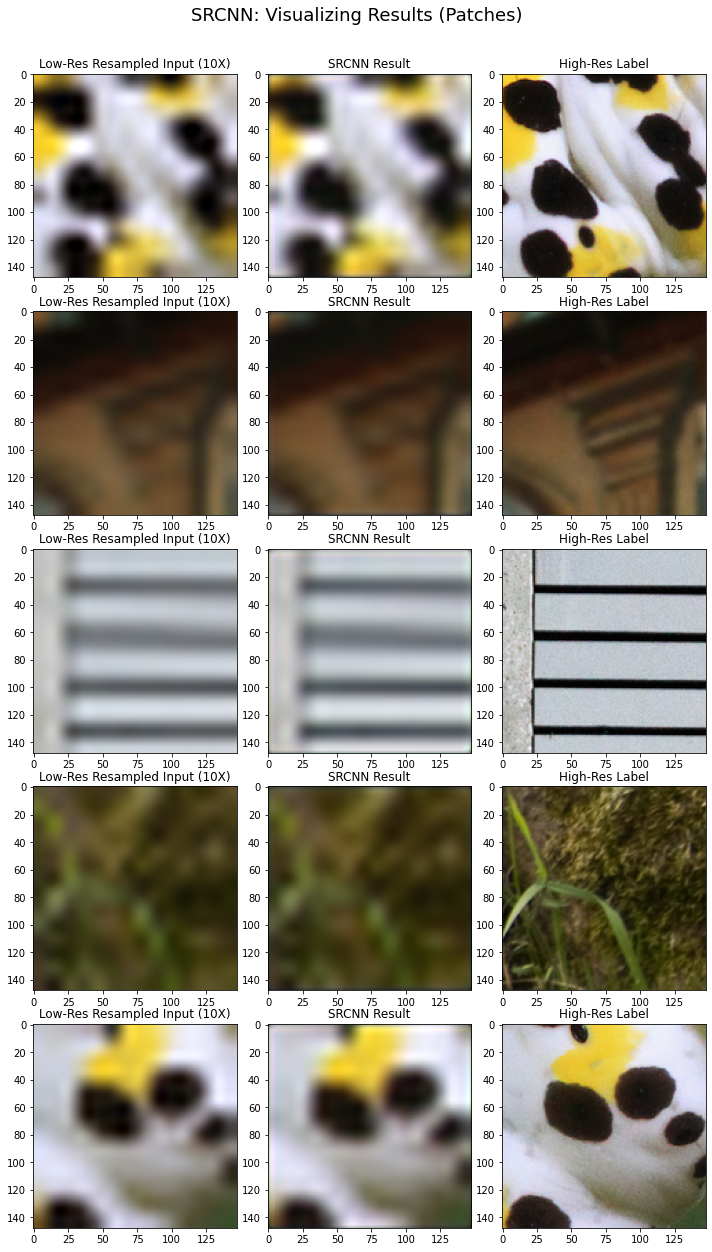

In [7]:
def plot_results(N_of_images_to_plot:int=2, col1:torch.Tensor=None, col2:torch.Tensor=None, col3:torch.Tensor=None, figsize=None, start_from_image=0):
    if figsize == None:
        figsize=(10,N_of_images_to_plot*3.5)
    fig, axs = plt.subplots(N_of_images_to_plot, 3, figsize=figsize)
    fig.suptitle('SRCNN: Visualizing Results (Patches)', fontsize=18, y=1)
    for i, ax in enumerate(axs):
        i+=start_from_image
        ax[0].imshow( cv2.cvtColor(         np.transpose(col1[i], (1, 2, 0) )          , cv2.COLOR_BGR2RGB)           ); ax[0].set_title("Low-Res Resampled Input ({}X)".format(resolution_div))
        ax[1].imshow( cv2.cvtColor(         np.transpose(col2[i], (1, 2, 0) )          , cv2.COLOR_BGR2RGB)           ); ax[1].set_title("SRCNN Result")
        ax[2].imshow( cv2.cvtColor(         np.transpose(col3[i], (1, 2, 0) )          , cv2.COLOR_BGR2RGB)           ); ax[2].set_title("High-Res Label")
    fig.tight_layout()
    plt.subplots_adjust(wspace=0.15, hspace=0.05)
    plt.savefig('./results/patch_results/SRCNN [{}-epochs] [{}-lr] [{}-optim] [{}-batch_size] [{}-train_size] [{}X].png'.format(epochs,learning_rate,str(type(optimizer)).split(".")[-1].split("'")[0],batch_size,n_patches,resolution_div), dpi=300)

plot_results(5,col1=IN_cpu_np, col2=result_cpu_np, col3=GT_cpu_np, start_from_image=2)
torch.save(mySRCNN.state_dict(),'./results/SRCNN [{}-epochs] [{}-lr] [{}-batchsize]'.format(epochs,learning_rate,batch_size))

### Plotting and Saving Loss over Epochs

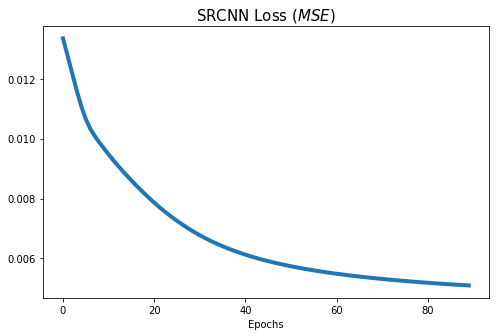

In [8]:
plt.figure(figsize=(8, 5))
plt.plot(loss_vals, linewidth=4)
plt.title('SRCNN Loss ($MSE$)',fontsize=15)
plt.xlabel("Epochs")
plt.savefig('./results/loss/SRCNN Loss [{}-epochs] [{}-lr] [{}-optim] [{}-batch_size] [{}-train_size] [{}X].png'.format(epochs,learning_rate,str(type(optimizer)).split(".")[-1].split("'")[0],batch_size,n_patches,resolution_div))

with open('./results/loss/SRCNN Loss [{}-epochs] [{}-lr] [{}-optim] [{}-batch_size] [{}-train_size] [{}X].pickle'.format(epochs,learning_rate,str(type(optimizer)).split(".")[-1].split("'")[0],batch_size,n_patches,resolution_div), 'wb') as handle:
    pickle.dump(loss_vals, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Evaluating Metrics (Patches)

In [9]:
patch_res = (255*(result_cpu_np.transpose(0,2,3,1).clip(0,1))).astype(np.uint8)
patch_in = (255*(IN_cpu_np.transpose(0,2,3,1))).astype(np.uint8)
patch_gt = (255*(GT_cpu_np.transpose(0,2,3,1))).astype(np.uint8)

In [10]:
from skimage.metrics import structural_similarity as ssim
# METRICS
result_str = '~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ METRIC RESULTS ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n'

# PSNR METRIC
result_str += '~~~~~~~~~~~~~>>>PSNR METRIC:\n'
psnr_res_vs_gt = []
psnr_in_vs_gt = []
for i in range(patch_res.shape[0]):
    temp_res_vs_gt = cv2.PSNR(patch_res[i], patch_gt[i])
    temp_in_vs_gt = cv2.PSNR(patch_in[i], patch_gt[i])
    psnr_res_vs_gt.append(temp_res_vs_gt)
    psnr_in_vs_gt.append(temp_in_vs_gt)
    result_str += 'Test Patch N{}\n\tPSNR(Result vs GroundTruth):\t{}\n\tPSNR(Input vs GroundTruth):\t{}\n'.format(i,temp_res_vs_gt,temp_in_vs_gt)
avg_psnr_res_vs_gt = np.mean(psnr_res_vs_gt)
avg_psnr_in_vs_gt = np.mean(psnr_in_vs_gt)
result_str += '\nTotal Average Results (PSNR):\n\tAverage PSNR(Result vs GroundTruth):\t{}\n\tAverage PSNR(Input vs GroundTruth):\t{}\n'.format(avg_psnr_res_vs_gt,avg_psnr_in_vs_gt)

# Average SSIM
result_str += '\n~~~~~~~~~~~~~>>>SSIM METRIC:\n'
avg_ssim_channels_res_vs_gt = []
avg_ssim_channels_in_vs_gt = []
for i in range(patch_res.shape[0]):
    ssim_channel1_res_vs_gt = ssim(patch_res[i][:,:,0],patch_gt[i][:,:,0],data_range=255)
    ssim_channel2_res_vs_gt = ssim(patch_res[i][:,:,1],patch_gt[i][:,:,1],data_range=255)
    ssim_channel3_res_vs_gt = ssim(patch_res[i][:,:,2],patch_gt[i][:,:,2],data_range=255)
    temp_ssim_res_vs_gt = ssim_channel1_res_vs_gt + ssim_channel2_res_vs_gt + ssim_channel3_res_vs_gt / 3
    avg_ssim_channels_res_vs_gt.append(temp_ssim_res_vs_gt)
    ssim_channel1_in_vs_gt = ssim(patch_in[i][:,:,0],patch_gt[i][:,:,0],data_range=255)
    ssim_channel2_in_vs_gt = ssim(patch_in[i][:,:,1],patch_gt[i][:,:,1],data_range=255)
    ssim_channel3_in_vs_gt = ssim(patch_in[i][:,:,2],patch_gt[i][:,:,2],data_range=255)
    temp_ssim_in_vs_gt = ssim_channel1_in_vs_gt + ssim_channel2_in_vs_gt + ssim_channel3_in_vs_gt / 3
    avg_ssim_channels_in_vs_gt.append(temp_ssim_in_vs_gt)
    result_str += 'Test Patch N{}\n\tSSIM(Result vs GroundTruth):\t{}\n\tSSIM(Input vs GroundTruth):\t{}\n'.format(i,temp_ssim_res_vs_gt,temp_ssim_in_vs_gt)
avg_ssim_res_vs_gt = np.mean(avg_ssim_channels_res_vs_gt)
avg_ssim_in_vs_gt = np.mean(avg_ssim_channels_in_vs_gt)
result_str += '\nTotal Average Results (SSIM):\n\tAverage SSIM(Result vs GroundTruth):\t{}\n\tAverage SSIM(Input vs GroundTruth):\t{}\n'.format(avg_ssim_res_vs_gt,avg_ssim_in_vs_gt)

# Average MSE
result_str += '\n~~~~~~~~~~~~~>>>MSE METRIC:\n'
mse_res_vs_gt = []
mse_in_vs_gt = []
avg_ssim_channels_in_vs_gt = []
for i in range(patch_res.shape[0]):
    temp_mse_res_vs_gt = np.square(np.subtract(patch_res[i],patch_gt[i])).mean()
    mse_res_vs_gt.append(temp_mse_res_vs_gt)
    temp_mse_in_vs_gt = np.square(np.subtract(patch_in[i],patch_gt[i])).mean()
    mse_in_vs_gt.append(temp_mse_in_vs_gt)
    result_str += 'Test Patch N{}\n\tMSE(Result vs GroundTruth):\t{}\n\tMSE(Input vs GroundTruth):\t{}\n'.format(i,temp_mse_res_vs_gt,temp_mse_in_vs_gt)
avg_mse_res_vs_gt = np.mean(mse_res_vs_gt)
avg_mse_in_vs_gt = np.mean(mse_in_vs_gt)
result_str += '\nTotal Average Results (MSE):\n\tAverage MSE(Result vs GroundTruth):\t{}\n\tAverage MSE(Input vs GroundTruth):\t{}\n'.format(avg_ssim_res_vs_gt,avg_ssim_in_vs_gt)
result_str += '\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~'

with open('./results/metrics/Metric Results [{}-epochs] [{}-lr] [{}-optim] [{}-batch_size] [{}-train_size] [{}X].txt'.format(epochs,learning_rate,str(type(optimizer)).split(".")[-1].split("'")[0],batch_size,n_patches,resolution_div), 'w') as f:
    f.write(result_str)

In [11]:
print(result_str)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ METRIC RESULTS ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~>>>PSNR METRIC:
Test Patch N0
	PSNR(Result vs GroundTruth):	33.74274067021078
	PSNR(Input vs GroundTruth):	35.38805673535074
Test Patch N1
	PSNR(Result vs GroundTruth):	34.75603475777641
	PSNR(Input vs GroundTruth):	38.48978285915875
Test Patch N2
	PSNR(Result vs GroundTruth):	18.30283592023452
	PSNR(Input vs GroundTruth):	18.89416467804184
Test Patch N3
	PSNR(Result vs GroundTruth):	31.457500837514758
	PSNR(Input vs GroundTruth):	33.38755792700117
Test Patch N4
	PSNR(Result vs GroundTruth):	14.395619885815671
	PSNR(Input vs GroundTruth):	14.35742648602864
Test Patch N5
	PSNR(Result vs GroundTruth):	22.97752954426329
	PSNR(Input vs GroundTruth):	23.170394032713947
Test Patch N6
	PSNR(Result vs GroundTruth):	21.507734147760786
	PSNR(Input vs GroundTruth):	22.083294514824946
Test Patch N7
	PSNR(Result vs GroundTruth):	18.29143092656509
	PSNR(Input vs GroundTruth):	18.3585693880802
Test Patch N8
	PSN

## TESTING THE MODEL (BIG IMAGE)

In [19]:
lr_big1 = lr_big[0].to(devO)
hr_big1 = hr_big[0].to(devO)
result_big= mySRCNN(lr_big1.view(-1, *list(lr_big1.shape) ))  # ONLY BIG
big_converted = result_big.cpu().detach().numpy()

In [20]:
mySRCNN = SRCNN()
mySRCNN.load_state_dict(torch.load('results\models\??????'))
mySRCNN = mySRCNN.to(devO)
result_big= mySRCNN(lr_big1.view(-1, *list(lr_big1.shape) ))
result_final = result_big.cpu().detach().numpy()

FileNotFoundError: [Errno 2] No such file or directory: 'results\\models\\??????'

In [21]:
result_rotated = result_final.transpose((0,1,3,2))
res_final_final = np.rot90(result_final,3,[2,3])
finalshitLR= torch.rot90(lr_big[0],3,[1,2])

NameError: name 'result_final' is not defined

### Saving BIG IMAGE PLOTS

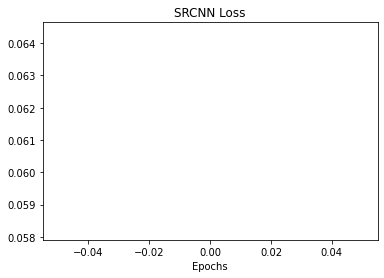

In [64]:
plot(finalshitLR, path = 'BigStar.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


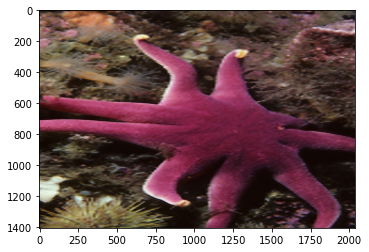

In [65]:
plot(res_final_final, path = 'BigStarRESULT.png')